# Method 6 - Best Ideas Medium Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['herf_pct'] > (1 / 3)) & (best_ideas['herf_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

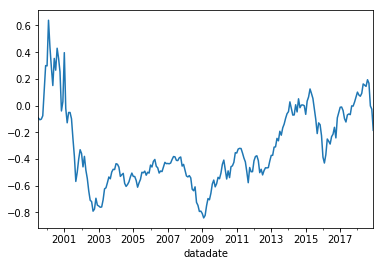

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.299463
2000-12-31   -0.207559
2001-12-31   -0.349933
2002-12-31   -0.619778
2003-12-31    1.046921
2004-12-31   -0.050998
2005-12-31    0.000025
2006-12-31    0.143139
2007-12-31   -0.010042
2008-12-31   -0.625344
2009-12-31    1.208316
2010-12-31    0.397981
2011-12-31   -0.219312
2012-12-31    0.158088
2013-12-31    0.605013
2014-12-31    0.063682
2015-12-31   -0.224803
2016-12-31    0.222375
2017-12-31    0.122440
2018-12-31   -0.232805
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     284.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.39e-87
Time:                        14:00:16   Log-Likelihood:                 394.86
No. Observations:                 234   AIC:                            -779.7
Df Residuals:                     229   BIC:                            -762.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.654      0.514      -0.004       0.008
mktrf          1.3983      0.084     16.568      0.000       1.232       1.565
me             0.6212      0.098      6.328      0.000       0.428       0.815
ia            -0.0900      0.149     -0.603      0.547      -0.384       0.204
roe           -1.3090      0.128    -10.249      0.000      -1.561      -1.057
==============================================================================
Omnibus:                      105.822   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              849.099
Skew:                           1.565   Prob(JB):                    4.17e-185
Kurtosis:                      11.791   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     82.13
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.90e-43
Time:                        14:00:16   Log-Likelihood:                 394.86
No. Observations:                 234   AIC:                            -779.7
Df Residuals:                     229   BIC:                            -762.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.668      0.504      -0.004       0.008
mktrf          1.3983      0.136     10.279      0.000       1.132       1.665
me             0.6212      0.109      5.698      0.000       0.407       0.835
ia            -0.0900      0.214     -0.420      0.675      -0.510       0.330
roe           -1.3090      0.208     -6.296      0.000      -1.716      -0.902
==============================================================================
Omnibus:                      105.822   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              849.099
Skew:                           1.565   Prob(JB):                    4.17e-185
Kurtosis:                      11.791   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     90.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.33e-46
Time:                        14:00:16   Log-Likelihood:                 394.86
No. Observations:                 234   AIC:                            -779.7
Df Residuals:                     229   BIC:                            -762.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.687      0.492      -0.004       0.008
mktrf          1.3983      0.140     10.009      0.000       1.124       1.672
me             0.6212      0.125      4.963      0.000       0.376       0.866
ia            -0.0900      0.207     -0.434      0.664      -0.497       0.317
roe           -1.3090      0.223     -5.873      0.000      -1.746      -0.872
==============================================================================
Omnibus:                      105.822   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              849.099
Skew:                           1.565   Prob(JB):                    4.17e-185
Kurtosis:                      11.791   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     199.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.30e-81
Time:                        14:00:16   Log-Likelihood:                 382.45
No. Observations:                 234   AIC:                            -752.9
Df Residuals:                     228   BIC:                            -732.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.003      0.226      0.822      -0.006       0.007
mktrf          1.5417      0.089     17.253      0.000       1.366       1.718
smb            0.6648      0.118      5.638      0.000       0.432       0.897
hml            0.1871      0.139      1.346      0.180      -0.087       0.461
rmw           -1.1745      0.157     -7.472      0.000      -1.484      -0.865
cma            0.0130      0.200      0.065      0.948      -0.381       0.407
==============================================================================
Omnibus:                      105.594   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              589.295
Skew:                           1.707   Prob(JB):                    1.09e-128
Kurtosis:                       9.985   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     137.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.13e-66
Time:                        14:00:16   Log-Likelihood:                 382.45
No. Observations:                 234   AIC:                            -752.9
Df Residuals:                     228   BIC:                            -732.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.003      0.239      0.811      -0.005       0.007
mktrf          1.5417      0.084     18.371      0.000       1.377       1.706
smb            0.6648      0.132      5.020      0.000       0.405       0.924
hml            0.1871      0.258      0.726      0.468      -0.318       0.692
rmw           -1.1745      0.223     -5.277      0.000      -1.611      -0.738
cma            0.0130      0.357      0.036      0.971      -0.688       0.714
==============================================================================
Omnibus:                      105.594   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              589.295
Skew:                           1.707   Prob(JB):                    1.09e-128
Kurtosis:                       9.985   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     156.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-71
Time:                        14:00:16   Log-Likelihood:                 382.45
No. Observations:                 234   AIC:                            -752.9
Df Residuals:                     228   BIC:                            -732.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.003      0.238      0.812      -0.005       0.007
mktrf          1.5417      0.077     20.032      0.000       1.391       1.693
smb            0.6648      0.127      5.233      0.000       0.416       0.914
hml            0.1871      0.231      0.810      0.418      -0.266       0.640
rmw           -1.1745      0.244     -4.808      0.000      -1.653      -0.696
cma            0.0130      0.348      0.037      0.970      -0.670       0.696
==============================================================================
Omnibus:                      105.594   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              589.295
Skew:                           1.707   Prob(JB):                    1.09e-128
Kurtosis:                       9.985   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     271.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.28e-85
Time:                        14:00:16   Log-Likelihood:                 390.22
No. Observations:                 234   AIC:                            -770.4
Df Residuals:                     229   BIC:                            -753.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.003     -0.676      0.500      -0.008       0.004
mktrf          1.5732      0.079     19.850      0.000       1.417       1.729
smb            1.2398      0.099     12.532      0.000       1.045       1.435
hml           -0.1261      0.098     -1.283      0.201      -0.320       0.068
umd           -0.5474      0.064     -8.489      0.000      -0.674      -0.420
==============================================================================
Omnibus:                       71.520   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              417.096
Skew:                           1.048   Prob(JB):                     2.68e-91
Kurtosis:                       9.196   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     163.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.47e-66
Time:                        14:00:16   Log-Likelihood:                 390.22
No. Observations:                 234   AIC:                            -770.4
Df Residuals:                     229   BIC:                            -753.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.003     -0.695      0.487      -0.008       0.004
mktrf          1.5732      0.110     14.238      0.000       1.357       1.790
smb            1.2398      0.106     11.684      0.000       1.032       1.448
hml           -0.1261      0.157     -0.803      0.422      -0.434       0.182
umd           -0.5474      0.086     -6.357      0.000      -0.716      -0.379
==============================================================================
Omnibus:                       71.520   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              417.096
Skew:                           1.048   Prob(JB):                     2.68e-91
Kurtosis:                       9.196   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     145.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.11e-61
Time:                        14:00:16   Log-Likelihood:                 390.22
No. Observations:                 234   AIC:                            -770.4
Df Residuals:                     229   BIC:                            -753.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.003     -0.730      0.465      -0.008       0.004
mktrf          1.5732      0.108     14.609      0.000       1.362       1.784
smb            1.2398      0.111     11.179      0.000       1.022       1.457
hml           -0.1261      0.151     -0.838      0.402      -0.421       0.169
umd           -0.5474      0.085     -6.462      0.000      -0.713      -0.381
==============================================================================
Omnibus:                       71.520   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              417.096
Skew:                           1.048   Prob(JB):                     2.68e-91
Kurtosis:                       9.196   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     130.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.70e-42
Time:                        14:00:16   Log-Likelihood:                 178.87
No. Observations:                 120   AIC:                            -347.7
Df Residuals:                     115   BIC:                            -333.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.005      0.905      0.368      -0.006       0.015
mktrf          1.2919      0.143      9.003      0.000       1.008       1.576
me             0.5078      0.142      3.583      0.000       0.227       0.789
ia            -0.2341      0.222     -1.055      0.294      -0.674       0.206
roe           -1.3731      0.196     -6.990      0.000      -1.762      -0.984
==============================================================================
Omnibus:                       42.808   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.960
Skew:                           1.210   Prob(JB):                     6.10e-34
Kurtosis:                       7.974   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     66.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.14e-29
Time:                        14:00:16   Log-Likelihood:                 178.87
No. Observations:                 120   AIC:                            -347.7
Df Residuals:                     115   BIC:                            -333.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.005      0.976      0.329      -0.005       0.014
mktrf          1.2919      0.205      6.292      0.000       0.889       1.694
me             0.5078      0.144      3.521      0.000       0.225       0.790
ia            -0.2341      0.303     -0.773      0.440      -0.828       0.360
roe           -1.3731      0.284     -4.839      0.000      -1.929      -0.817
==============================================================================
Omnibus:                       42.808   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.960
Skew:                           1.210   Prob(JB):                     6.10e-34
Kurtosis:                       7.974   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     85.03
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.95e-33
Time:                        14:00:16   Log-Likelihood:                 178.87
No. Observations:                 120   AIC:                            -347.7
Df Residuals:                     115   BIC:                            -333.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.082      0.279      -0.004       0.014
mktrf          1.2919      0.213      6.057      0.000       0.874       1.710
me             0.5078      0.163      3.111      0.002       0.188       0.828
ia            -0.2341      0.299     -0.782      0.434      -0.821       0.353
roe           -1.3731      0.311     -4.416      0.000      -1.983      -0.764
==============================================================================
Omnibus:                       42.808   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.960
Skew:                           1.210   Prob(JB):                     6.10e-34
Kurtosis:                       7.974   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     90.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.32e-38
Time:                        14:00:16   Log-Likelihood:                 172.62
No. Observations:                 120   AIC:                            -333.2
Df Residuals:                     114   BIC:                            -316.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.006      0.832      0.407      -0.007       0.016
mktrf          1.6057      0.160     10.029      0.000       1.289       1.923
smb            0.5957      0.181      3.285      0.001       0.236       0.955
hml           -0.0542      0.222     -0.244      0.808      -0.494       0.386
rmw           -1.0272      0.262     -3.920      0.000      -1.546      -0.508
cma            0.1008      0.287      0.351      0.726      -0.468       0.669
==============================================================================
Omnibus:                       54.810   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.498
Skew:                           1.686   Prob(JB):                     2.12e-38
Kurtosis:                       7.829   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     45.81
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.88e-26
Time:                        14:00:16   Log-Likelihood:                 172.62
No. Observations:                 120   AIC:                            -333.2
Df Residuals:                     114   BIC:                            -316.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.005      1.045      0.296      -0.004       0.014
mktrf          1.6057      0.152     10.558      0.000       1.308       1.904
smb            0.5957      0.185      3.219      0.001       0.233       0.958
hml           -0.0542      0.284     -0.191      0.848      -0.611       0.502
rmw           -1.0272      0.295     -3.481      0.000      -1.606      -0.449
cma            0.1008      0.418      0.241      0.810      -0.719       0.920
==============================================================================
Omnibus:                       54.810   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.498
Skew:                           1.686   Prob(JB):                     2.12e-38
Kurtosis:                       7.829   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     51.02
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.61e-27
Time:                        14:00:16   Log-Likelihood:                 172.62
No. Observations:                 120   AIC:                            -333.2
Df Residuals:                     114   BIC:                            -316.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.114      0.265      -0.004       0.013
mktrf          1.6057      0.130     12.322      0.000       1.350       1.861
smb            0.5957      0.171      3.490      0.000       0.261       0.930
hml           -0.0542      0.272     -0.199      0.842      -0.588       0.480
rmw           -1.0272      0.329     -3.120      0.002      -1.673      -0.382
cma            0.1008      0.403      0.250      0.803      -0.690       0.891
==============================================================================
Omnibus:                       54.810   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.498
Skew:                           1.686   Prob(JB):                     2.12e-38
Kurtosis:                       7.829   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     139.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.45e-43
Time:                        14:00:16   Log-Likelihood:                 182.36
No. Observations:                 120   AIC:                            -354.7
Df Residuals:                     115   BIC:                            -340.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.005      0.161      0.872      -0.009       0.011
mktrf          1.5723      0.123     12.804      0.000       1.329       1.815
smb            1.1933      0.140      8.535      0.000       0.916       1.470
hml           -0.3297      0.140     -2.355      0.020      -0.607      -0.052
umd           -0.5456      0.086     -6.320      0.000      -0.717      -0.375
==============================================================================
Omnibus:                       37.193   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.442
Skew:                           1.017   Prob(JB):                     3.88e-30
Kurtosis:                       7.791   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     124.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.23e-41
Time:                        14:00:16   Log-Likelihood:                 182.36
No. Observations:                 120   AIC:                            -354.7
Df Residuals:                     115   BIC:                            -340.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.005      0.179      0.858      -0.008       0.010
mktrf          1.5723      0.166      9.457      0.000       1.246       1.898
smb            1.1933      0.133      8.986      0.000       0.933       1.454
hml           -0.3297      0.212     -1.556      0.120      -0.745       0.086
umd           -0.5456      0.086     -6.359      0.000      -0.714      -0.377
==============================================================================
Omnibus:                       37.193   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.442
Skew:                           1.017   Prob(JB):                     3.88e-30
Kurtosis:                       7.791   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     126.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.20e-41
Time:                        14:00:17   Log-Likelihood:                 182.36
No. Observations:                 120   AIC:                            -354.7
Df Residuals:                     115   BIC:                            -340.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.004      0.195      0.845      -0.007       0.009
mktrf          1.5723      0.169      9.288      0.000       1.240       1.904
smb            1.1933      0.139      8.576      0.000       0.921       1.466
hml           -0.3297      0.217     -1.521      0.128      -0.755       0.095
umd           -0.5456      0.084     -6.500      0.000      -0.710      -0.381
==============================================================================
Omnibus:                       37.193   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.442
Skew:                           1.017   Prob(JB):                     3.88e-30
Kurtosis:                       7.791   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     194.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.12e-48
Time:                        14:00:17   Log-Likelihood:                 239.32
No. Observations:                 114   AIC:                            -468.6
Df Residuals:                     109   BIC:                            -455.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.134      0.894      -0.006       0.006
mktrf          1.4636      0.089     16.417      0.000       1.287       1.640
me             0.8556      0.138      6.216      0.000       0.583       1.128
ia             0.1275      0.191      0.668      0.506      -0.251       0.506
roe           -1.2903      0.168     -7.691      0.000      -1.623      -0.958
==============================================================================
Omnibus:                       11.529   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.321
Skew:                           0.535   Prob(JB):                     0.000471
Kurtosis:                       4.443   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     206.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.29e-50
Time:                        14:00:17   Log-Likelihood:                 239.32
No. Observations:                 114   AIC:                            -468.6
Df Residuals:                     109   BIC:                            -455.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.170      0.865      -0.005       0.004
mktrf          1.4636      0.091     16.080      0.000       1.285       1.642
me             0.8556      0.158      5.421      0.000       0.546       1.165
ia             0.1275      0.199      0.642      0.521      -0.262       0.517
roe           -1.2903      0.221     -5.839      0.000      -1.723      -0.857
==============================================================================
Omnibus:                       11.529   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.321
Skew:                           0.535   Prob(JB):                     0.000471
Kurtosis:                       4.443   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     242.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.61e-53
Time:                        14:00:17   Log-Likelihood:                 239.32
No. Observations:                 114   AIC:                            -468.6
Df Residuals:                     109   BIC:                            -455.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.190      0.849      -0.005       0.004
mktrf          1.4636      0.082     17.883      0.000       1.303       1.624
me             0.8556      0.182      4.689      0.000       0.498       1.213
ia             0.1275      0.221      0.576      0.564      -0.306       0.561
roe           -1.2903      0.237     -5.433      0.000      -1.756      -0.825
==============================================================================
Omnibus:                       11.529   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.321
Skew:                           0.535   Prob(JB):                     0.000471
Kurtosis:                       4.443   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     141.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.64e-46
Time:                        14:00:17   Log-Likelihood:                 235.02
No. Observations:                 114   AIC:                            -458.0
Df Residuals:                     108   BIC:                            -441.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.003     -0.804      0.423      -0.009       0.004
mktrf          1.5101      0.089     17.024      0.000       1.334       1.686
smb            0.7939      0.144      5.513      0.000       0.508       1.079
hml            0.5920      0.184      3.223      0.002       0.228       0.956
rmw           -1.1737      0.225     -5.219      0.000      -1.619      -0.728
cma           -0.2280      0.285     -0.799      0.426      -0.794       0.338
==============================================================================
Omnibus:                        6.128   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                7.017
Skew:                           0.315   Prob(JB):                       0.0299
Kurtosis:                       4.039   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     188.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.21e-51
Time:                        14:00:17   Log-Likelihood:                 235.02
No. Observations:                 114   AIC:                            -458.0
Df Residuals:                     108   BIC:                            -441.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.003     -0.803      0.422      -0.009       0.004
mktrf          1.5101      0.061     24.685      0.000       1.390       1.630
smb            0.7939      0.131      6.042      0.000       0.536       1.051
hml            0.5920      0.169      3.501      0.000       0.261       0.923
rmw           -1.1737      0.248     -4.737      0.000      -1.659      -0.688
cma           -0.2280      0.263     -0.868      0.385      -0.743       0.287
==============================================================================
Omnibus:                        6.128   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                7.017
Skew:                           0.315   Prob(JB):                       0.0299
Kurtosis:                       4.039   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     182.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.53e-51
Time:                        14:00:17   Log-Likelihood:                 235.02
No. Observations:                 114   AIC:                            -458.0
Df Residuals:                     108   BIC:                            -441.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.003     -0.869      0.385      -0.008       0.003
mktrf          1.5101      0.059     25.442      0.000       1.394       1.626
smb            0.7939      0.134      5.943      0.000       0.532       1.056
hml            0.5920      0.147      4.032      0.000       0.304       0.880
rmw           -1.1737      0.213     -5.502      0.000      -1.592      -0.756
cma           -0.2280      0.282     -0.809      0.418      -0.780       0.324
==============================================================================
Omnibus:                        6.128   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                7.017
Skew:                           0.315   Prob(JB):                       0.0299
Kurtosis:                       4.039   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     152.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.94e-44
Time:                        14:00:17   Log-Likelihood:                 227.37
No. Observations:                 114   AIC:                            -444.7
Df Residuals:                     109   BIC:                            -431.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.003     -1.089      0.279      -0.010       0.003
mktrf          1.5499      0.094     16.520      0.000       1.364       1.736
smb            1.0723      0.146      7.330      0.000       0.782       1.362
hml            0.4989      0.151      3.311      0.001       0.200       0.798
umd           -0.4205      0.114     -3.699      0.000      -0.646      -0.195
==============================================================================
Omnibus:                       10.995   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               20.693
Skew:                           0.345   Prob(JB):                     3.21e-05
Kurtosis:                       4.970   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     237.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.66e-53
Time:                        14:00:17   Log-Likelihood:                 227.37
No. Observations:                 114   AIC:                            -444.7
Df Residuals:                     109   BIC:                            -431.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.003     -1.193      0.233      -0.010       0.002
mktrf          1.5499      0.071     21.933      0.000       1.411       1.688
smb            1.0723      0.130      8.265      0.000       0.818       1.327
hml            0.4989      0.172      2.904      0.004       0.162       0.836
umd           -0.4205      0.126     -3.344      0.001      -0.667      -0.174
==============================================================================
Omnibus:                       10.995   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               20.693
Skew:                           0.345   Prob(JB):                     3.21e-05
Kurtosis:                       4.970   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     295.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.52e-57
Time:                        14:00:17   Log-Likelihood:                 227.37
No. Observations:                 114   AIC:                            -444.7
Df Residuals:                     109   BIC:                            -431.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.003     -1.328      0.184      -0.009       0.002
mktrf          1.5499      0.063     24.707      0.000       1.427       1.673
smb            1.0723      0.112      9.557      0.000       0.852       1.292
hml            0.4989      0.172      2.903      0.004       0.162       0.836
umd           -0.4205      0.124     -3.395      0.001      -0.663      -0.178
==============================================================================
Omnibus:                       10.995   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               20.693
Skew:                           0.345   Prob(JB):                     3.21e-05
Kurtosis:                       4.970   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""